In [25]:
# Standars libraries
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sns
import pickle
import itertools as it
from collections import Counter
import pyspark
from pyspark import *
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark.sql import functions as F


# Utilities functions
import sys
sys.path.append('/home/fanfou/Panorama/notebooks/utils')

print("Python version")
print (sys.version)
print("Version info.")
print (sys.version_info)

from visualization import *
from tools import *

# Display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 199)


Python version
3.6.9 (default, Nov  7 2019, 10:44:02) 
[GCC 8.3.0]
Version info.
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)


## Load all tweets of Coronavirus and virus stats 

In [26]:
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext
all_tweets = spark.read.json("/mnt/datastore/data/coronavirus/*.json");
all_tweets.count()

15957794

In [186]:
all_tweets.printSchema()

root
 |-- author_handle: string (nullable = true)
 |-- geo_city: string (nullable = true)
 |-- geo_country: string (nullable = true)
 |-- geo_location: string (nullable = true)
 |-- geo_state: string (nullable = true)
 |-- lang: string (nullable = true)
 |-- likes: long (nullable = true)
 |-- main: string (nullable = true)
 |-- permalink: string (nullable = true)
 |-- published: string (nullable = true)
 |-- replied: boolean (nullable = true)
 |-- shared_type: string (nullable = true)
 |-- shares: long (nullable = true)
 |-- source_followers: long (nullable = true)
 |-- source_following: long (nullable = true)



In [12]:
coronavirus = pd.read_csv("/mnt/datastore/data/coronavirus_2020-03-05.csv", sep=";")
coronavirus['date'] = pd.to_datetime(coronavirus['Date'])
coronavirus_count = coronavirus.groupby([coronavirus.Pays, coronavirus.date.dt.year, coronavirus.date.dt.month, coronavirus.date.dt.day])[['Infections', 'Guerisons', 'Deces']].sum()
coronavirus_count.index.names = ['Pays', 'Year', 'Month','Day']
coronavirus_count = coronavirus_count.reset_index()
coronavirus_count['date'] = pd.to_datetime(coronavirus_count[['Year', 'Month', 'Day']])
coronavirus_count = coronavirus_count[['date', 'Pays', 'Infections', 'Guerisons', 'Deces']]
coronavirus_count = coronavirus_count.sort_values(by=['date'], ascending=True)

## France

In [176]:
count_FR = all_tweets.filter(col('geo_country') == 'FR').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_FR['date'] = pd.to_datetime(count_FR['date'])
count_FR = count_FR.sort_values(by=['date'], ascending=True)

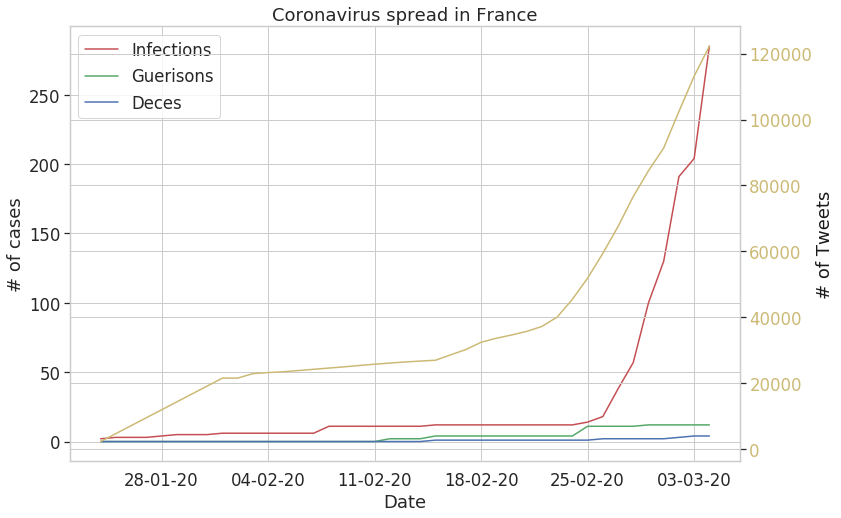

In [222]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'France']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in France")

plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_FR['date'])]['date'],
    count_FR[count_FR['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Italy

In [177]:
count_IT = all_tweets.filter(col('geo_country') == 'IT').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_IT['date'] = pd.to_datetime(count_IT['date'])
count_IT = count_IT.sort_values(by=['date'], ascending=True)

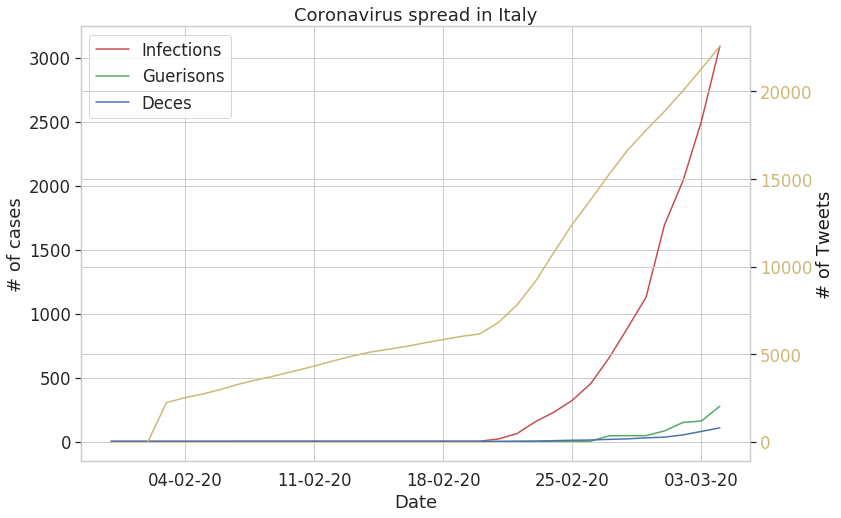

In [45]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'Italie']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Italy")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_IT['date'])]['date'],
    count_IT[count_IT['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Switzerland

In [178]:
count_CH = all_tweets.filter(col('geo_country') == 'CH').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_CH['date'] = pd.to_datetime(count_CH['date'])
count_CH = count_CH.sort_values(by=['date'], ascending=True)

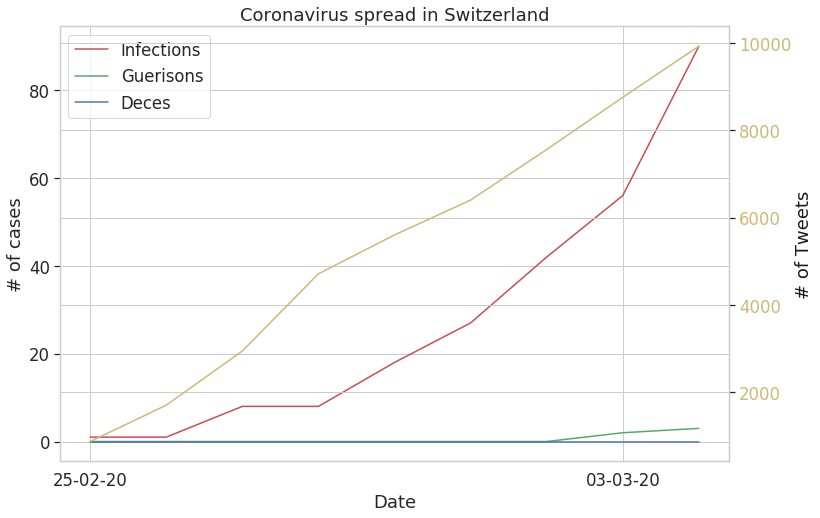

In [46]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'Suisse']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Switzerland")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_CH['date'])]['date'],
    count_CH[count_CH['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Allemagne

In [179]:
count_DE = all_tweets.filter(col('geo_country') == 'DE').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_DE['date'] = pd.to_datetime(count_DEU['date'])
count_DE = count_DEU.sort_values(by=['date'], ascending=True)

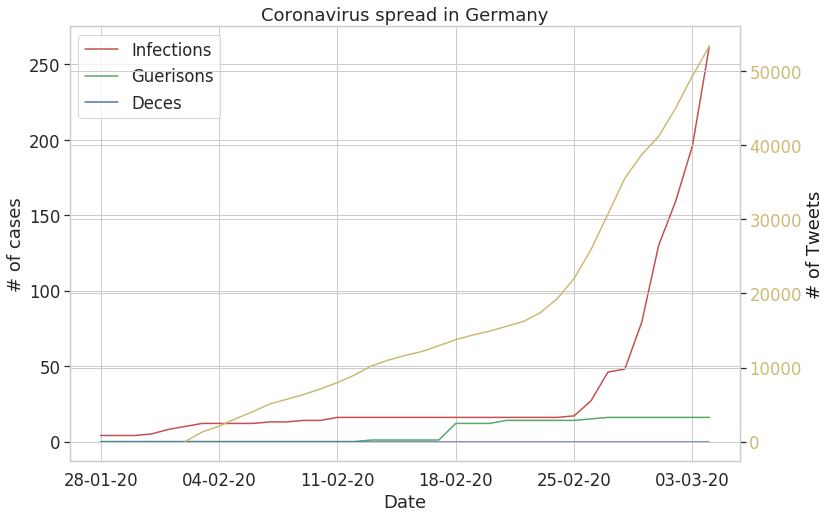

In [52]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'Allemagne']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in Germany")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_DE['date'])]['date'],
    count_DE[count_DE['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## USA

In [130]:
count_US = all_tweets.filter(col('geo_country') == 'US').select(F.date_format('published','yyyy-MM-dd').alias('date')).groupby("date").count().toPandas()
count_US['date'] = pd.to_datetime(count_US['date'])
count_US = count_US.sort_values(by=['date'], ascending=True)

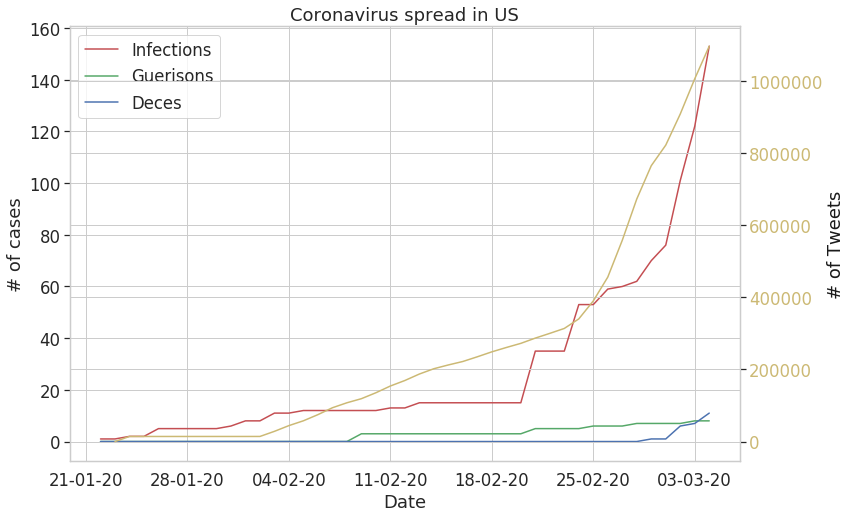

In [55]:
#df_virus = coronavirus_count.groupby('date').sum().reset_index()
df_virus = coronavirus_count[coronavirus_count['Pays'] == 'États-Unis']
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df_virus['date'],
        df_virus['Infections'].rolling(window=1).mean(),
        '-o',
        color='r', label="Infections", marker='')

ax.plot(df_virus['date'],
        df_virus['Guerisons'].rolling(window=1).mean(),
        '-o',
        color='g', label="Guerisons", marker='')

ax.plot(df_virus['date'],
        df_virus['Deces'].rolling(window=1).mean(),
        '-o',
        color='b', label="Deces", marker='')


ax.set_ylabel('# of cases')
ax.set(xlabel="Date",
       title="Coronavirus spread in US")
plt.legend()
ax2 = ax.twinx()
ax2.plot(df_virus[df_virus['date'].isin(count_US['date'])]['date'],
    count_US[count_US['date'].isin(df_virus['date'])]['count'].cumsum(),
    '-o',
    color='y', label="users", marker='')
ax2.set_ylabel('# of Tweets', color='k')
ax2.tick_params(axis='y', labelcolor='y')


# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

plt.show()

## Putting all together

In [180]:
coronavirus_by_country = pd.pivot_table(coronavirus_count, values=['Infections'], index=['date'],
                    columns=['Pays']).fillna(method='ffill').fillna(0)

In [260]:
nb_habitants_it = 60.48e6
nb_habitants_fr = 66.99e6
nb_habitants_ch = 8.57e6
nb_habitants_us = 327.2e6
nb_habitants_de = 82.79e6

blue_col   = "#3498db"
red_col    = "#e74c3c"
green_col  = "#2ecc71"
orange_col = "#ff9214"

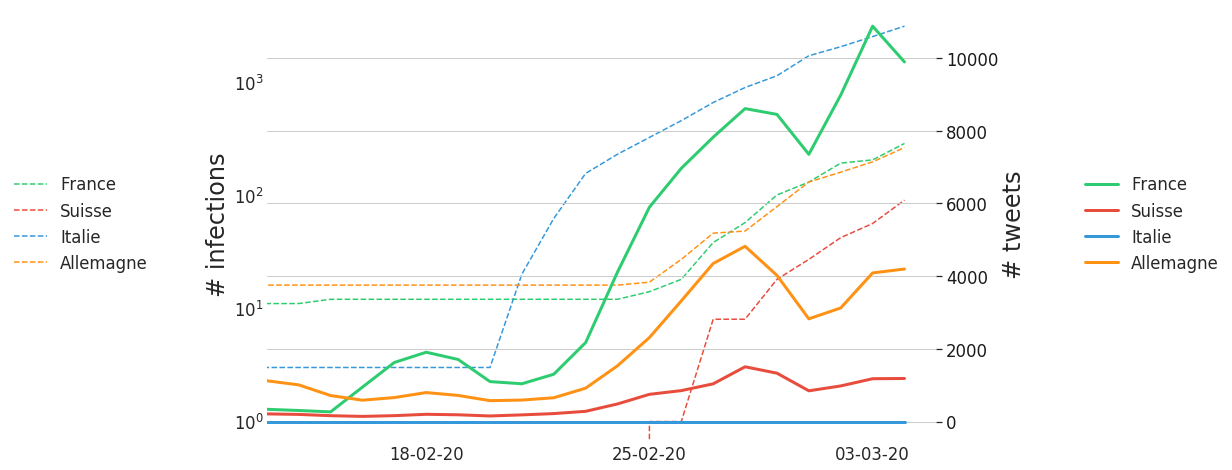

<Figure size 432x288 with 0 Axes>

In [314]:
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'France'].rolling(window=1).mean(),
        '--',
        color=green_col, label="France", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Suisse'].rolling(window=1).mean(),
        '--',
        color=red_col, label="Suisse", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Italie'].rolling(window=1).mean(),
        '--',
        color=blue_col, label="Italie", marker='')

ax.plot(coronavirus_by_country.index,
        coronavirus_by_country['Infections', 'Allemagne'].rolling(window=1).mean(),
        '--',
        color=orange_col, label="Allemagne", marker='')

plt.yscale("log")
ax.set_ylabel('# infections', fontsize=24)

#ax.set(xlabel="Date",title="")

plt.legend()

ax2 = ax.twinx()
ax2.set_ylabel('# tweets', fontsize=24)

dates = coronavirus_count[~coronavirus_count['date'].isin(count_FR['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_FR_norm = count_FR.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_FR_norm['count'] = count_FR['count']/nb_habitants_fr

ax2.plot(coronavirus_by_country.index,
    count_FR_norm[count_FR_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=green_col, label="France", marker='')

dates = coronavirus_count[~coronavirus_count['date'].isin(count_IT['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_IT_norm = count_IT.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_IT_norm['count'] = count_IT['count'] /nb_habitants_it

dates = coronavirus_count[~coronavirus_count['date'].isin(count_CH['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_CH_norm = count_CH.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_CH_norm['count'] = count_CH['count'] /nb_habitants_ch
ax2.plot(coronavirus_by_country.index,
    count_CH_norm[count_CH_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=red_col, label="Suisse", marker='')

ax2.plot(coronavirus_by_country.index,
    count_IT_norm[count_IT_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=blue_col, label="Italie", marker='')

dates = coronavirus_count[~coronavirus_count['date'].isin(count_DE['date'])]['date'].unique()
nan = np.empty(dates.size)
nan[:] = np.nan
dates = pd.DataFrame({'date': dates, 'count': nan})
count_DE_norm = count_DE.append(dates).sort_values(by=['date'], ascending=True).fillna(method='ffill').fillna(0)
#count_DE_norm['count'] = count_DE['count'] /nb_habitants_de

ax2.plot(coronavirus_by_country.index,
    count_DE_norm[count_DE_norm['date'].isin(coronavirus_by_country.index)]['count'].rolling(window=2).mean(),
    '', linewidth=3,
    color=orange_col, label="Allemagne", marker='')

ax2.tick_params(axis='y', labelcolor='k')

#plt.yscale("log")

plt.legend()

ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 0.5), frameon=False)

#plt.ylim((10e0, 10e3))

plt.xlim([datetime.date(2020, 2, 13), datetime.date(2020, 3, 5)])

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))

ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False);ax2.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);ax2.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False);ax2.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False);ax2.spines['left'].set_visible(False)

plt.show()

plt.savefig("/home/fanfou/Panorama/figures/TweetsVsCorona.pdf", format="pdf")

In [262]:
interest = pd.read_csv('/mnt/datastore/data/gtrend_by_country.csv')
interest_it = interest[interest['country'] == 'IT'][['date', 'Coronavirus']]
interest_it = interest_it.rename(columns={"Coronavirus": "interest"})
interest_it['date'] = pd.to_datetime(interest_it['date'])
interest_it.head()

,date,interest
360,2019-12-12,0
361,2019-12-13,0
362,2019-12-14,0
363,2019-12-15,0
364,2019-12-16,0


In [282]:
medias_it = pd.read_csv('/mnt/datastore/data/medias/media_italy.csv', header=None)
medias_it = medias_it.rename(columns={0: "date", 1:'medias'})
medias_it['date'] = pd.to_datetime(medias_it['date']).dt.strftime('%Y-%m-%d')
medias_it['date'] = pd.to_datetime(medias_it['date'])
medias_it.head()

,date,medias
0,2020-01-09,3
1,2020-01-10,0
2,2020-01-11,0
3,2020-01-12,0
4,2020-01-13,0


In [283]:
print(count_IT['date'].dtype)
print(medias_it['date'].dtype)
print(interest_it['date'].dtype)

datetime64[ns]
datetime64[ns]
datetime64[ns]


In [268]:
count_IT = count_IT.rename(columns={'count': "tweets"})
count_IT['date'] = pd.to_datetime(count_IT['date'])
count_IT.head()

,date,tweets
5,2019-09-08,2
34,2020-01-02,2
2,2020-01-03,3
45,2020-01-08,3
35,2020-01-09,12


In [285]:
merge = interest_it.merge(medias_it, left_on='date', right_on='date', how='left').fillna(0)
merge = merge.merge(count_IT, left_on='date', right_on='date', how='left').fillna(0)

,date,interest,medias,tweets
0,2019-12-12,0,0.0,0.0
1,2019-12-13,0,0.0,0.0
2,2019-12-14,0,0.0,0.0
3,2019-12-15,0,0.0,0.0
4,2019-12-16,0,0.0,0.0


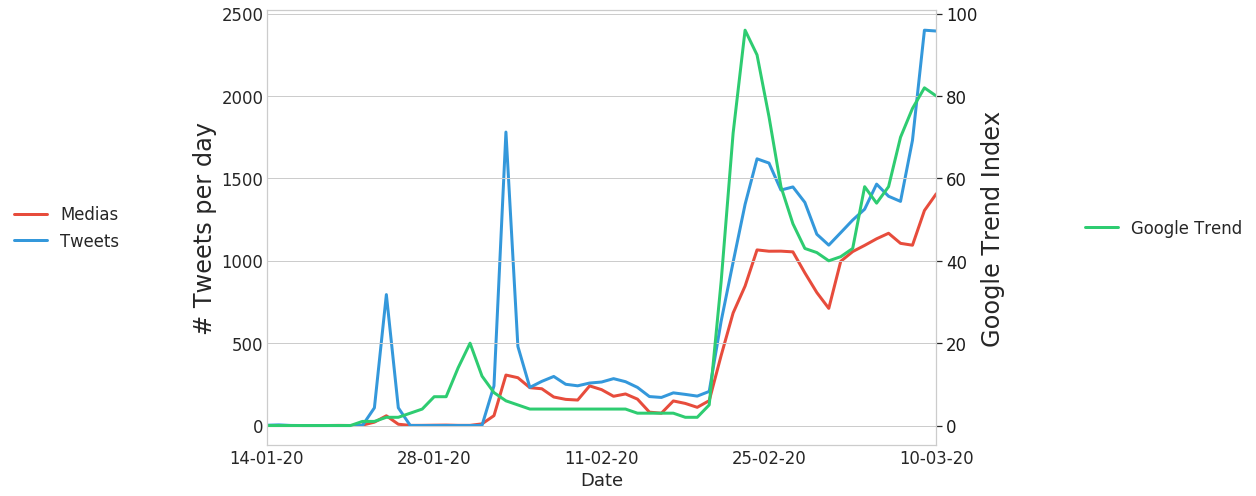

<Figure size 432x288 with 0 Axes>

In [312]:
from scipy.ndimage.filters import gaussian_filter1d
# Prettier plotting with seaborn
sns.set(font_scale=1.5, style="whitegrid")

sns_cmap = sns.light_palette("Navy", as_cmap=True)

fig, ax = plt.subplots(figsize=(12, 8))

medias = gaussian_filter1d(merge['medias'], sigma=.5)
ax.plot(merge['date'],
        medias,
        '-', linewidth=3,
        color=red_col, label="Medias", marker='')

#plt.fill_between(merge['date'], medias, facecolor=red_col, alpha=0.5)

tweets = gaussian_filter1d(merge['tweets'], sigma=.5)
ax.plot(merge['date'],
        tweets,
        '-', linewidth=3,
        color=blue_col, label="Tweets", marker='')

#plt.fill_between(merge['date'],tweets, facecolor=blue_col, alpha=0.5)

ax.set_ylabel('# Tweets per day', fontsize=24)
ax.set(xlabel="Date",title="")
plt.legend()


ax2 = ax.twinx()
ax2.set_ylabel('Google Trend Index', fontsize=24)

trends = gaussian_filter1d(merge['interest'], sigma=.5)
ax2.plot(merge['date'],
    trends,
    '', linewidth=3,
    color=green_col, label="Google Trend", marker='')
#plt.fill_between(merge['date'], trends, facecolor=green_col, alpha=0.5)

ax2.tick_params(axis='y', labelcolor='k')

plt.xlim([datetime.date(2020, 1, 14), datetime.date(2020, 3, 10)])
plt.legend()

# Format the x axis
ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=2))
ax.xaxis.set_major_formatter(DateFormatter("%d-%m-%y"))

# Ensure ticks fall once every other week (interval=2) 
#ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
ax2.legend(loc='center left', bbox_to_anchor=(1.2, 0.5), frameon=False)
ax.legend(loc='center left', bbox_to_anchor=(-0.4, 0.5), frameon=False)

ax.grid(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
ax.spines['top'].set_visible(False);
ax.spines['right'].set_visible(False);
ax.spines['bottom'].set_visible(False);
ax.spines['left'].set_visible(False);



plt.show()
plt.savefig("/home/fanfou/Panorama/figures/TrendVsMediasVsTweets.pdf", format="pdf")